Exploratory Data Analysis 

In [50]:
#% pip install openpyxl
import os, re, configparser
import pandas as pd
import numpy as np
from globals import glob
from utilities_database import prepare_data, prepare_database, consult_database, clear_databases, retrieve_data, rename_index, get_date, get_sigma, rename_limits_table
from utilities_analysis import mean_calculator, limits_generator, ini_generator, RyR, z_score_filter, reset_df
from utilities_plotting import plot_scatter, plot_capability
import ipywidgets as widgets
from ipywidgets import HBox
import _db_tools as db
##Widgets creation
auto_position = widgets.Checkbox(value=False, description='Auto position', layout={'width': '200px'})
mean_slider = widgets.FloatSlider(value=0.35, min=0.3, max=0.4, step=0.0005, readout_format='.3f', description='Y-axis mean')
range_slider = widgets.IntSlider(value=5, min=1, max=10, step=1, description='Y-axis zoom')

In [51]:
##Database access
table_list = consult_database("input.db", verbose=False)
default_measurements = consult_database("input.db", verbose=False, filter=glob.tooling+"_measurements_")[-1]
default_limits = consult_database("input.db", verbose=False, filter=glob.tooling+"_limits_")[-1]
tables = widgets.SelectMultiple(options=table_list, value=(default_measurements, default_limits), description='input db', rows=10, layout={'width': '600px'})
print('Select the tables to load with "CTRL" or "SHIFT" pressed:')
display(tables)

Select the tables to load with "CTRL" or "SHIFT" pressed:


SelectMultiple(description='input db', index=(6, 3), layout=Layout(width='600px'), options=('TOP_PASSAT_B9_lim…

In [61]:
##Data extraction
MEAS = retrieve_data("input.db", next((string for string in tables.value if "measurements" in string), None))
LIMITS = retrieve_data("input.db", next((string for string in tables.value if "limits" in string), None))
if MEAS is None or MEAS.empty or LIMITS is None or LIMITS.empty:
    print("WARNING: Some data might not be correctly retrieved")

Table *TOP_PASSAT_B9_measurements_2023y_12m_13d_14h_49m_51s* retrieved succesfully.
Table *TOP_PASSAT_B9_limits_2023y_12m_13d_14h_49m_51s* retrieved succesfully.


In [53]:
##Data preparation
MEAS_format = rename_index(MEAS)
new_column_names = {old_col: f"test: {i+1}" for i, old_col in enumerate(MEAS_format.columns)}
MEAS_format.rename(columns=new_column_names, inplace=True)
##Measurements review
print("Measurements:")
MEAS_format #Shows the df in html format

Measurements:


,test: 1,test: 2,test: 3,test: 4,test: 5,test: 6,test: 7,test: 8,test: 9,test: 10,...,test: 40,test: 41,test: 42,test: 43,test: 44,test: 45,test: 46,test: 47,test: 48,test: 49
Guia_Luz_Blanco_FB1_X,0.3248,0.3261,0.3248,0.3252,0.3253,0.3249,0.3257,0.3256,0.3256,0.3244,...,0.3244,0.3246,0.3258,0.3241,0.3246,0.3253,0.3231,0.3244,0.3241,0.3249
Guia_Luz_Blanco_FB1_Y,0.3480,0.3489,0.3480,0.3491,0.3482,0.3485,0.3485,0.3497,0.3486,0.3476,...,0.3475,0.3492,0.3497,0.3481,0.3492,0.3497,0.3462,0.3479,0.3487,0.3483
Guia_Luz_Blanco_FB2_X,0.3340,0.3332,0.3313,0.3316,0.3329,0.3312,0.3326,0.3314,0.3330,0.3329,...,0.3325,0.3309,0.3312,0.3319,0.3307,0.3305,0.3305,0.3325,0.3305,0.3325
Guia_Luz_Blanco_FB2_Y,0.3590,0.3586,0.3568,0.3573,0.3584,0.3570,0.3582,0.3573,0.3586,0.3585,...,0.3583,0.3572,0.3573,0.3579,0.3571,0.3568,0.3565,0.3583,0.3569,0.3584
Guia_Luz_Blanco_FB3_X,0.3347,0.3385,0.3375,0.3383,0.3384,0.3383,0.3385,0.3384,0.3388,0.3387,...,0.3383,0.3382,0.3381,0.3383,0.3380,0.3384,0.3393,0.3384,0.3384,0.3390
Guia_Luz_Blanco_FB3_Y,0.3556,0.3659,0.3651,0.3658,0.3658,0.3657,0.3659,0.3659,0.3661,0.3661,...,0.3657,0.3658,0.3656,0.3657,0.3655,0.3658,0.3663,0.3658,0.3658,0.3663
Guia_Luz_Blanco_FB4_X,0.3247,0.3247,0.3250,0.3251,0.3244,0.3252,0.3247,0.3243,0.3246,0.3239,...,0.3233,0.3237,0.3234,0.3236,0.3235,0.3237,0.3238,0.3238,0.3233,0.3233
Guia_Luz_Blanco_FB4_Y,0.3463,0.3472,0.3467,0.3468,0.3471,0.3469,0.3474,0.3472,0.3464,0.3469,...,0.3460,0.3462,0.3468,0.3458,0.3462,0.3471,0.3463,0.3464,0.3468,0.3468
Guia_Luz_Blanco_FB5_X,0.3344,0.3318,0.3335,0.3336,0.3312,0.3334,0.3312,0.3315,0.3335,0.3310,...,0.3333,0.3333,0.3309,0.3333,0.3330,0.3311,0.3327,0.3332,0.3306,0.3309
Guia_Luz_Blanco_FB5_Y,0.3601,0.3585,0.3599,0.3599,0.3582,0.3599,0.3582,0.3585,0.3599,0.3582,...,0.3598,0.3599,0.3583,0.3598,0.3597,0.3583,0.3595,0.3599,0.3582,0.3582


In [54]:
##Limits review
LIMITS_format = rename_index(LIMITS)
LIMITS_format.columns = ['LO_LIMIT', 'HI_LIMIT']
print("limits:")
LIMITS_format

limits:


,LO_LIMIT,HI_LIMIT
Guia_Luz_Blanco_FB1_X,0.3140,0.3390
Guia_Luz_Blanco_FB1_Y,0.3453,0.3789
Guia_Luz_Blanco_FB2_X,0.3230,0.3480
Guia_Luz_Blanco_FB2_Y,0.3453,0.3789
Guia_Luz_Blanco_FB3_X,0.3180,0.3430
Guia_Luz_Blanco_FB3_Y,0.3453,0.3789
Guia_Luz_Blanco_FB4_X,0.3140,0.3390
Guia_Luz_Blanco_FB4_Y,0.3453,0.3789
Guia_Luz_Blanco_FB5_X,0.3230,0.3480
Guia_Luz_Blanco_FB5_Y,0.3453,0.3789


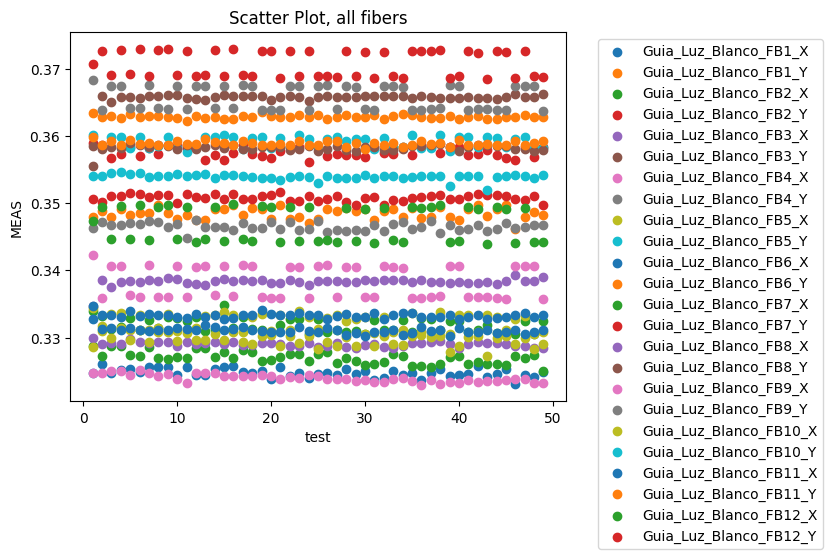

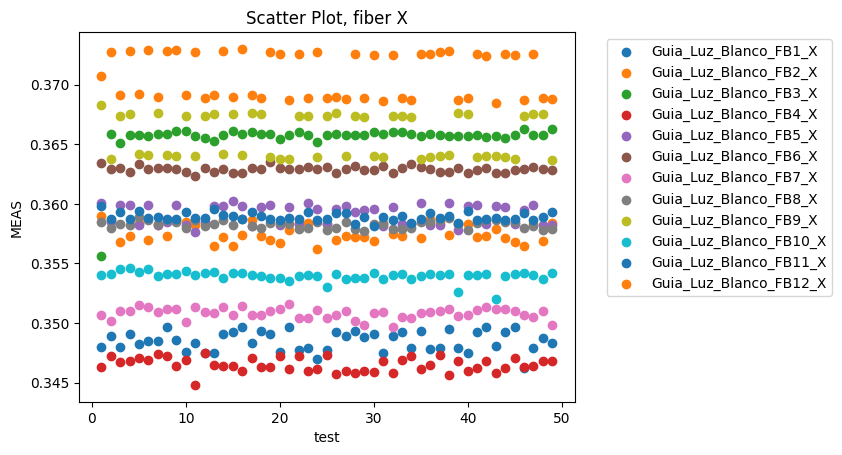

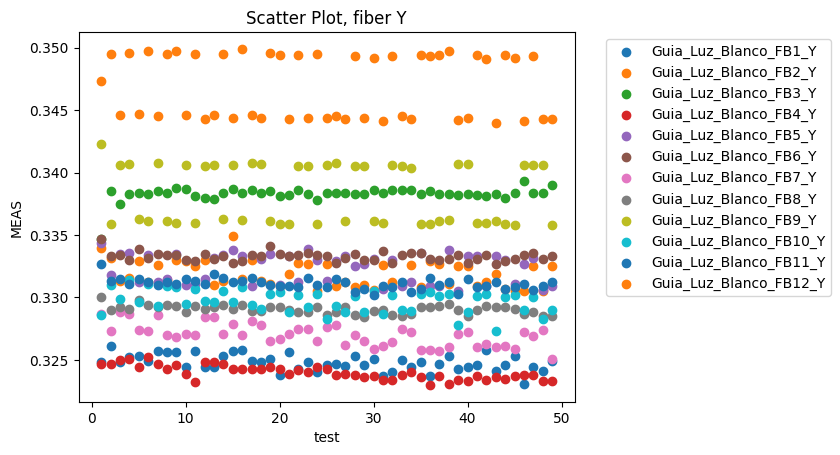

In [55]:
##Visualizations
plot_scatter(MEAS, title='Scatter Plot, all fibers', xlabel='test', ylabel='MEAS') #Plot all guides
plot_scatter(MEAS, title='Scatter Plot, fiber X', xlabel='test', ylabel='MEAS', filter='x') #Plot x axis values
plot_scatter(MEAS, title='Scatter Plot, fiber Y', xlabel='test', ylabel='MEAS', filter='y') #Plot y axis values

In [56]:
##Descriptive statistics
resume = rename_index(MEAS.transpose().describe().transpose()) #Transpose the df first due to describe() working in columns.
resume

,count,mean,std,min,25%,50%,75%,max
Guia_Luz_Blanco_FB1_X,49.0,0.324796,0.000645,0.3231,0.3244,0.3248,0.3253,0.3261
Guia_Luz_Blanco_FB1_Y,49.0,0.348498,0.000819,0.3462,0.3479,0.3485,0.3492,0.3497
Guia_Luz_Blanco_FB2_X,49.0,0.331855,0.001032,0.3305,0.3310,0.3315,0.3327,0.3349
Guia_Luz_Blanco_FB2_Y,49.0,0.357639,0.000739,0.3562,0.3571,0.3574,0.3584,0.3590
Guia_Luz_Blanco_FB3_X,49.0,0.338300,0.000599,0.3347,0.3383,0.3384,0.3385,0.3393
Guia_Luz_Blanco_FB3_Y,49.0,0.365596,0.001476,0.3556,0.3657,0.3658,0.3659,0.3663
Guia_Luz_Blanco_FB4_X,49.0,0.324008,0.000560,0.3230,0.3236,0.3239,0.3244,0.3252
Guia_Luz_Blanco_FB4_Y,49.0,0.346508,0.000577,0.3448,0.3461,0.3464,0.3469,0.3475
Guia_Luz_Blanco_FB5_X,49.0,0.332345,0.001178,0.3305,0.3311,0.3329,0.3333,0.3344
Guia_Luz_Blanco_FB5_Y,49.0,0.359124,0.000823,0.3576,0.3583,0.3596,0.3598,0.3602


Analysis of faulty fibers

In [57]:
##Analysis of faulty fibers
std = pd.DataFrame(resume['std'])  #Get the std values
fiber_number = rename_index(pd.DataFrame(range(1, std.shape[0]+1))).rename(columns={0: 'Fiber number'}) #Add an absolute number for quick identification
largest = pd.concat([std, fiber_number], axis = 1).sort_values(by="std", ascending=False)[:5]  #Filter the 5 largest values
largest

,std,Fiber number
Guia_Luz_Blanco_FB12_X,0.002540,23
Guia_Luz_Blanco_FB9_X,0.002367,17
Guia_Luz_Blanco_FB12_Y,0.001900,24
Guia_Luz_Blanco_FB9_Y,0.001793,18
Guia_Luz_Blanco_FB3_Y,0.001476,6


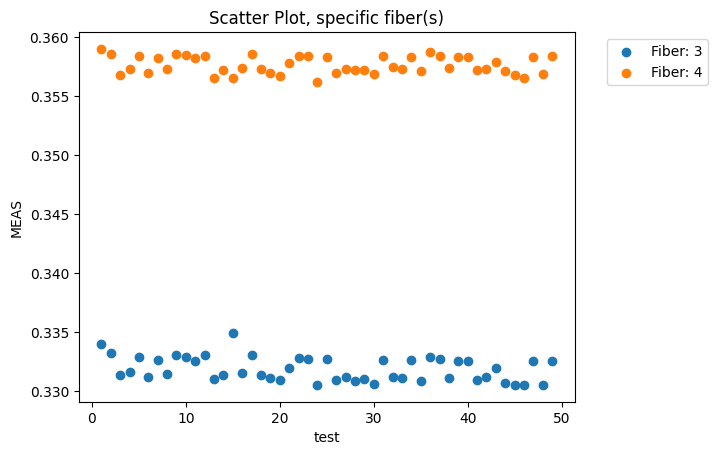

In [70]:
##Specific fibers visualization
if auto_position.value is False:
    range_mapping = [0.05 - 0.005 * (range_slider.value)]
    yrange = [mean_slider.value - range_mapping[0], mean_slider.value + range_mapping[0]]
else:
    range_mapping = None; yrange = None
display(HBox([auto_position, mean_slider, range_slider]))
plot_scatter(MEAS, title='Scatter Plot, specific fiber(s)', xlabel='test', ylabel='MEAS', filter=[3, 4], yrange=yrange)